### MACHINE TRANSLATION MODEL WITH TEACHER FORCING

Here is the work pipeline:
1. Read data from txt files and split into train and test dataframe.
2. Tokenize sentences and transform to one hot encode sequence data.
3. Build model using teacher forcing then get the weights.
4. Build encoder and decoder, set weights of each layer from the weights in teacher-forcing model.
5. Test some sentences.

In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (10.0, 5.0)
%matplotlib inline

### 1. Read data from txt file

In [2]:
en_sents = list()
with open('vocab_en.txt', encoding='utf-8') as txt_file:
    for line in txt_file:
        new_line = line.rstrip('\n')
        en_sents.append(new_line)

fr_sents = list()
fr_sents_se = list()
with open('vocab_fr.txt', encoding='utf-8') as txt_file:
    for line in txt_file.readlines():
        new_line = line.rstrip('\n')
        fr_sents.append(new_line)
        
        new_line_se = 'sos ' + new_line + ' eos'
        fr_sents_se.append(new_line_se)
        
df = pd.DataFrame({'english_sentence':en_sents, 'french_sentence': fr_sents, 'french_sentence_se': fr_sents_se})
df.head()

,english_sentence,french_sentence,french_sentence_se
0,"new jersey is sometimes quiet during autumn , ...",new jersey est parfois calme pendant l' automn...,sos new jersey est parfois calme pendant l' au...
1,the united states is usually chilly during jul...,les états-unis est généralement froid en juill...,sos les états-unis est généralement froid en j...
2,"california is usually quiet during march , and...","california est généralement calme en mars , et...",sos california est généralement calme en mars ...
3,the united states is sometimes mild during jun...,"les états-unis est parfois légère en juin , et...",sos les états-unis est parfois légère en juin ...
4,"your least liked fruit is the grape , but my l...","votre moins aimé fruit est le raisin , mais mo...","sos votre moins aimé fruit est le raisin , mai..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137860 entries, 0 to 137859
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   english_sentence    137860 non-null  object
 1   french_sentence     137860 non-null  object
 2   french_sentence_se  137860 non-null  object
dtypes: object(3)
memory usage: 3.2+ MB


In [4]:
#shuffle indicies to shuffle the rows
indicies = np.array(df.index)
np.random.shuffle(indicies)
indicies

array([18689, 23969,  3278, ..., 43601, 66002, 37131], dtype=int64)

#### Split data into train and test dataframe after shuffling row

In [5]:
train_size, test_size = int((137860/10) * 8), int((137860/10) * 2)

train_indicies, test_indicies = indicies[:train_size], indicies[train_size:]

train_df = df.iloc[train_indicies, :]
test_df = df.iloc[test_indicies, :]

In [8]:
import tensorflow as tf
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Conv1D, Dense, Flatten, Input, MaxPooling1D, GRU, RepeatVector, \
                        Dropout, BatchNormalization, TimeDistributed, LSTM, Dropout
from tensorflow.python.keras.layers.merge import concatenate
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

### 2. Tokenize sentences then transform to one hot encode sequence data

In [11]:
en_token = Tokenizer(oov_token='unknown')
en_token.fit_on_texts(train_df['english_sentence'])

fr_se_token = Tokenizer(oov_token='unknown')
fr_se_token.fit_on_texts(train_df['french_sentence_se'])

In [12]:
en_index_to_word = en_token.index_word
fr_se_index_to_word = fr_se_token.index_word

en_word_to_index = en_token.word_index
fr_se_word_to_index = fr_se_token.word_index

In [13]:
max_en_len = max([len(i) for i in en_token.texts_to_sequences(train_df['english_sentence'])])
max_fr_se_len = max([len(i) for i in fr_se_token.texts_to_sequences(train_df['french_sentence_se'])])
print(max_en_len, max_fr_se_len)

15 23


In [15]:
en_vocab = len(en_token.index_word) + 1
fr_se_vocab = len(fr_se_token.index_word) + 1
print(en_vocab, fr_se_vocab)

201 345


In [16]:
en_oh = to_categorical(np.arange(0,en_vocab))
fr_se_oh = to_categorical(np.arange(0, fr_se_vocab))
print(en_oh.shape, fr_se_oh.shape)

(201, 201) (345, 345)


In [17]:
#function word to oh
def word2oh(word, language='en', se=False):
    oh = ''
    if language == 'en':
        index = en_word_to_index[word]
        oh = en_oh[index]
    elif language =='fr' and se == True:
        index = fr_se_word_to_index[word]
        oh = fr_se_oh[index]        
    return oh

In [25]:
#function oh to word
def oh2word(ohs, language='en', se=False):
    index = np.argmax(ohs[0])
    if index == 0: 
        word = 'unknown'
    else:
        if language=='en':
            word = en_index_to_word[index]
        elif language =='fr' and se == True:
            word = fr_se_index_to_word[index]
    return word

In [18]:
#function sentence to oh
def sent2oh(sentence, language='en', se=False, reverse=False):
    oh = list()
    if language=='en':
        sequence = en_token.texts_to_sequences([sentence])
        sequence = pad_sequences(sequence, padding='post', maxlen=max_en_len) #add padding
        if reverse == True:
            sequence = sequence[:, ::-1]
        for seq in sequence:
            oh.append(en_oh[seq])
    elif language == 'fr' and se == True:
        sequence = fr_se_token.texts_to_sequences([sentence])
        sequence = pad_sequences(sequence, padding='post', maxlen=max_fr_se_len)
        if reverse == True:
            sequence = sequence[:, ::-1]
        for seq in sequence:
            oh.append(fr_se_oh[seq])       
    return np.array(oh)

In [19]:
train_en_oh_rev = np.vstack([(sent2oh(sent, reverse=True)) for sent in train_df['english_sentence']])
train_fr_se_oh = np.vstack([(sent2oh(sent, language='fr', se=True)) for sent in train_df['french_sentence_se']])

print(train_en_oh_rev.shape, train_fr_se_oh.shape)

(110288, 15, 201) (110288, 23, 345)


In [20]:
test_en_oh_rev = np.vstack([(sent2oh(sent, reverse=True)) for sent in test_df['english_sentence']])
test_fr_se_oh = np.vstack([(sent2oh(sent, language='fr', se=True)) for sent in test_df['french_sentence_se']])

print(test_en_oh_rev.shape, test_fr_se_oh.shape)

(27572, 15, 201) (27572, 23, 345)


### 3. Build model using teacher forcing then get the weights

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15, 201)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 22, 345)]    0                                            
__________________________________________________________________________________________________
gru (GRU)                       [(None, 201), (None, 243009      input_1[0][0]                    
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 22, 201)      329841      input_2[0][0]                    
             

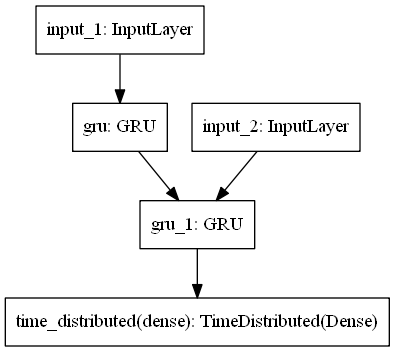

In [21]:
hsize = en_vocab
#encoder
en_input = Input(shape=(max_en_len, en_vocab))
en_gru = GRU(en_vocab, return_state=True)
en_out, en_state = en_gru(en_input)

#decoder
de_input = Input(shape=(max_fr_se_len-1, fr_se_vocab))
de_gru = GRU(en_vocab, return_sequences=True)
de_out = de_gru(de_input, initial_state=en_state)

#prediction layer
de_dense = Dense(fr_se_vocab, activation='softmax')
de_dense_time = TimeDistributed(de_dense)
de_pred = de_dense_time(de_out)

#compiling the model
nmt = Model(inputs=[en_input, de_input], outputs=de_pred)

#summarize model
nmt.summary()

#plot graph
plot_model(nmt, to_file='layout.png')

In [22]:
train_fr_se_oh_x = train_fr_se_oh[:,:-1,:] #don't get last word 'eos'
train_fr_se_oh_y = train_fr_se_oh[:,1:,:] #don't get first word 'sos'
train_fr_se_oh_x.shape

(110288, 22, 345)

In [23]:
nmt.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
early_stopping = EarlyStopping(monitor='val_acc', patience=5)
nmt.fit([train_en_oh_rev, train_fr_se_oh_x], train_fr_se_oh_y, epochs=10, validation_split=0.2, callbacks=[early_stopping])

Train on 88230 samples, validate on 22058 samples
Epoch 1/10
88230/88230 [==============================] - 379s 4ms/sample - loss: 0.6741 - acc: 0.8120 - val_loss: 0.2741 - val_acc: 0.9088
Epoch 2/10
88230/88230 [==============================] - 382s 4ms/sample - loss: 0.1527 - acc: 0.9514 - val_loss: 0.0696 - val_acc: 0.9817
Epoch 3/10
88230/88230 [==============================] - 383s 4ms/sample - loss: 0.0516 - acc: 0.9852 - val_loss: 0.0378 - val_acc: 0.9888
Epoch 4/10
88230/88230 [==============================] - 390s 4ms/sample - loss: 0.0348 - acc: 0.9893 - val_loss: 0.0372 - val_acc: 0.9885
Epoch 5/10
88230/88230 [==============================] - 380s 4ms/sample - loss: 0.0273 - acc: 0.9913 - val_loss: 0.0239 - val_acc: 0.9926
Epoch 6/10
88230/88230 [==============================] - 352s 4ms/sample - loss: 0.0221 - acc: 0.9929 - val_loss: 0.0239 - val_acc: 0.9923
Epoch 7/10
88230/88230 [==============================] - 354s 4ms/sample - loss: 0.0187 - acc: 0.9940 - val_l

In [24]:
#get the weights from each layer
en_gru_w = en_gru.get_weights()
de_gru_w = de_gru.get_weights()
de_dense_w = de_dense.get_weights()

### 4. Build encoder and decoder, set weights of each layer from the weights in teacher-forcing model.

In [26]:
hsize = en_vocab
#encoder
en_input = Input(shape=(max_en_len, en_vocab))
en_gru = GRU(en_vocab, return_state=True)
en_out, en_state = en_gru(en_input)
encoder = Model(inputs=en_input, outputs=en_state)

In [29]:
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 15, 201)]         0         
_________________________________________________________________
gru_2 (GRU)                  [(None, 201), (None, 201) 243009    
Total params: 243,009
Trainable params: 243,009
Non-trainable params: 0
_________________________________________________________________


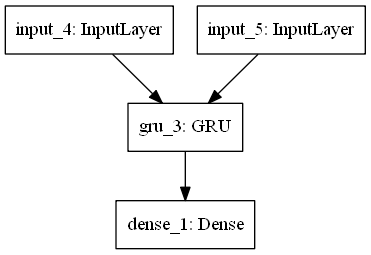

In [27]:
#decoder
de_input = Input(shape=(1, fr_se_vocab))
de_state_in = Input(shape=(hsize,)) #---> = result from encoder.predict

#decoder's interim layers
de_gru = GRU(hsize, return_state=True)
de_out, de_state_out = de_gru(de_input, initial_state=de_state_in)
de_dense = Dense(fr_se_vocab, activation='softmax')
de_pred = de_dense(de_out)
decoder = Model(inputs=[de_input, de_state_in], outputs=[de_pred, de_state_out])

#plot encoder
plot_model(decoder, to_file='layout.png')

In [28]:
decoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1, 345)]     0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 201)]        0                                            
__________________________________________________________________________________________________
gru_3 (GRU)                     [(None, 201), (None, 329841      input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 345)          69690       gru_3[0][0]                

In [30]:
en_gru.set_weights(en_gru_w)
de_gru.set_weights(de_gru_w)
de_dense.set_weights(de_dense_w)

### 5. Test some sentences

In [44]:
#function to translate english to french
def translate_to_french(english_sentence):
    #convert english sentence to one hot
    en_sent_oh = sent2oh(english_sentence, language='en', reverse=True)
    #convert word 'sos' to oh
    de_w_seq = word2oh('sos',language='fr',se=True)
    de_w_seq = de_w_seq.reshape(1,1,fr_se_vocab)
    #get the en_state from result in encoder
    de_state = encoder.predict(en_sent_oh)
    
    fr_sent = ''
    for _ in range(max_fr_se_len):
        de_pred, de_state = decoder.predict([de_w_seq, de_state])
        de_word = oh2word(de_pred, language='fr', se=True)
        de_w_seq = word2oh(de_word, language='fr', se=True).reshape(1,1,fr_se_vocab)
        if de_word == 'eos': break
        fr_sent += de_word + ' '
    return fr_sent    

In [46]:
#test on 10 sentences
for i in test_df.index[:10]:
    pred_fr_sent = translate_to_french(test_df['english_sentence'][i])
    fr_sent = test_df['french_sentence'][i]
    print('Predict French sentence: ' , pred_fr_sent)
    print('True French sentence: ', fr_sent)
    print('==================')

Predict French sentence:  nous aimons les raisins citrons verts et les poires 
True French sentence:  nous aimons les raisins , citrons verts , et les poires .
Predict French sentence:  mon fruit est moins aimé la chaux mais notre moins aimé est l'orange 
True French sentence:  mon fruit est moins aimé la chaux , mais notre moins aimé est l'orange .
Predict French sentence:  ils aiment les oranges les citrons et les pamplemousses 
True French sentence:  ils aiment les oranges , les citrons et les pamplemousses .
Predict French sentence:  l'orange est son fruit préféré mais la poire est notre préféré 
True French sentence:  l'orange est son fruit préféré , mais la poire est notre préféré .
Predict French sentence:  les états unis est jamais de neige en mars et il pleut en janvier 
True French sentence:  les états-unis est jamais de neige en mars , et il pleut en janvier .
Predict French sentence:  les états unis est parfois sec au mois de mai mais il est relaxant parfois en avril 
True 